We are now going to apply some machine learning techniques to predict PSEC stock returns. We will first use a linear regression model, then an LSTM model to compare the results of both. Also, a different dataset will be used for this analysis. I am using it as an extension of the previous EDA performed. I will pick a shorter timeframe (2 years) to properly capture the stock price movement of PSEC.

First, let's import the required packages.

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

Next, we will download the PSEC OHLC data and save it to a CSV file. The timeframe will be from April 2021 to April 2023. Based on the visualization of PSEC's stock in the EDA, I felt this time range was the best representation of PSEC's price movements without any black swan events.

In [65]:
tickerSymbol = 'PSEC'

tickerData = yf.Ticker(tickerSymbol)

tickerDf = tickerData.history(period='1d', start='2021-4-1', end='2023-4-1')

tickerDf.to_csv('PSEC1.csv')




Let's take a look at the CSV file.

In [66]:
df = pd.read_csv('PSEC1.csv')

df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2021-04-01 00:00:00-04:00,6.304005,6.385875,6.271257,6.377688,1788600,0.0,0.0
1,2021-04-05 00:00:00-04:00,6.385877,6.451373,6.353129,6.426812,1876800,0.0,0.0
2,2021-04-06 00:00:00-04:00,6.451373,6.492308,6.426811,6.467747,1808800,0.0,0.0
3,2021-04-07 00:00:00-04:00,6.492306,6.582363,6.475932,6.516867,2948700,0.0,0.0
4,2021-04-08 00:00:00-04:00,6.541429,6.549616,6.443185,6.533242,1661400,0.0,0.0


Just like in the previous project, we are going to fix the date column and make it the index of the dataframe.

In [67]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-04-01 00:00:00-04:00,6.304005,6.385875,6.271257,6.377688,1788600,0.0,0.0
2021-04-05 00:00:00-04:00,6.385877,6.451373,6.353129,6.426812,1876800,0.0,0.0
2021-04-06 00:00:00-04:00,6.451373,6.492308,6.426811,6.467747,1808800,0.0,0.0
2021-04-07 00:00:00-04:00,6.492306,6.582363,6.475932,6.516867,2948700,0.0,0.0
2021-04-08 00:00:00-04:00,6.541429,6.549616,6.443185,6.533242,1661400,0.0,0.0


We are going to drop Dividends and Stock Splits. We will not need these columns for the analysis

In [68]:
df = df.drop(['Dividends', 'Stock Splits'], axis=1)

df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2021-04-01 00:00:00-04:00,6.304005,6.385875,6.271257,6.377688,1788600
2021-04-05 00:00:00-04:00,6.385877,6.451373,6.353129,6.426812,1876800
2021-04-06 00:00:00-04:00,6.451373,6.492308,6.426811,6.467747,1808800
2021-04-07 00:00:00-04:00,6.492306,6.582363,6.475932,6.516867,2948700
2021-04-08 00:00:00-04:00,6.541429,6.549616,6.443185,6.533242,1661400


Ok now that we have our dataframe the way want it, lets take a look at PSEC's close price over time

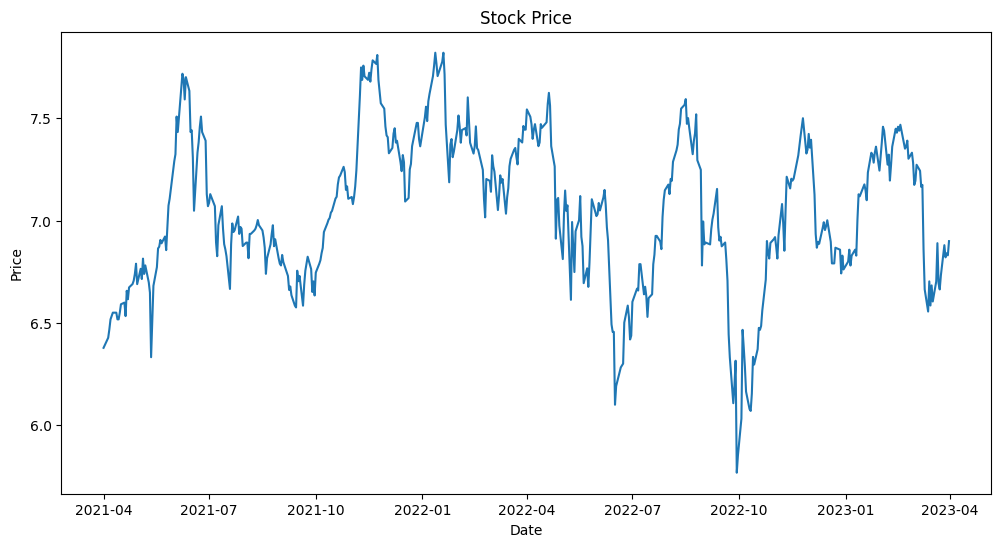

In [69]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'])
plt.title('Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In my opinion, this is a much better graph compared to the one in my EDA. It is a better representation of PSEC's price and its trend. I think it will also be more beneficial for our machine learning model later on.

We need to create features to feed into our ML model. I will start with some of the metrics we used in the EDA. These will later be added to the full dataframe for the ML model:

1. Average daily return
2. Daily return volatility
3. Intraday Range
4. 20-day Moving Average
5. 50-day Moving Average
6. Volume Weighted Average (Observing buyer and seller effect on the price)

We will calculate the following metrics to get an idea of the dataset we are working with:

1. Annual return
2. Annual volatility
3. Total return
4. Sharpe ratio
5. Skewness
6. Kurtosis

In [132]:
df['Returns'] = np.log(df['Close']) - np.log(df['Close'].shift(1))

psec_daily_growth = 1 + df['Returns']
geo_mean = np.prod(psec_daily_growth)**(1/len(psec_daily_growth))
psec_annual_ret = (geo_mean**252 - 1)*100
psec_annual_vol = (df['Returns'].std() * np.sqrt(252)) * 100

cumulative_returns = (1 + df['Returns']).cumprod() - 1
total_return = cumulative_returns[-1]

sharpe_ratio = ((psec_annual_ret / 100) / (psec_annual_vol / 100)) * np.sqrt(252)


print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f'Annual return: {psec_annual_ret: .2f}%')
print(f"Annual volatility: {psec_annual_vol: .2f}%")
print(f"Total Return: {total_return:.2%}")

Sharpe Ratio: 0.4623
Annual return:  0.73%
Annual volatility:  25.23%
Total Return: 1.47%


Something important to note: returns and the Sharpe ratio are a lot smaller now, but the volatility is consistent. I believe this further shows that this dataset is a better representation of PSEC's price.

Let's work on the features 

In [70]:
# Compute Average Daily Return
df['Average Daily Return'] = df['Close'].pct_change()

# Compute Log Returns
df['Returns'] = np.log(df['Close']) - np.log(df['Close'].shift(1))

df['21D_Volatility'] = df['Returns'].rolling(window=21).std()

# Compute Daily Return Volatility
df['Daily Return Volatility'] = df['Average Daily Return'].rolling(window=21).std()

# Compute Intraday Range
df['Intraday Range'] = df['High'] - df['Low']

# Compute 20-day Moving Average
df['20-day Moving Average'] = df['Close'].rolling(window=20).mean()

# Compute 50-day Moving Average
df['50-day Moving Average'] = df['Close'].rolling(window=50).mean()



df['VWAP'] = (df['Volume'] * (df['High'] + df['Low'] + df['Close'])) / (3 * df['Volume'])

df.head()

,Open,High,Low,Close,Volume,Average Daily Return,Returns,21D_Volatility,Daily Return Volatility,Intraday Range,20-day Moving Average,50-day Moving Average,VWAP
Date,,,,,,,,,,,,,
2021-04-01 00:00:00-04:00,6.304005,6.385875,6.271257,6.377688,1788600,NaN,NaN,NaN,NaN,0.114619,NaN,NaN,6.344940
2021-04-05 00:00:00-04:00,6.385877,6.451373,6.353129,6.426812,1876800,0.007703,0.007673,NaN,NaN,0.098244,NaN,NaN,6.410438
2021-04-06 00:00:00-04:00,6.451373,6.492308,6.426811,6.467747,1808800,0.006369,0.006349,NaN,NaN,0.065496,NaN,NaN,6.462289
2021-04-07 00:00:00-04:00,6.492306,6.582363,6.475932,6.516867,2948700,0.007595,0.007566,NaN,NaN,0.106431,NaN,NaN,6.525054
2021-04-08 00:00:00-04:00,6.541429,6.549616,6.443185,6.533242,1661400,0.002513,0.002510,NaN,NaN,0.106431,NaN,NaN,6.508681


Due to calculating the 20-day moving average, 50-day moving average, average daily return, and log returns, we have created NaN values that we need to take care of. We want to give the model as much data as possible. If we remove the NaN values, we would lose 50 samples from the dataset. Before doing so, I want to check to see if the dataset is normally distributed. This will help me determine if I should fill in the missing data with mean values or median values.

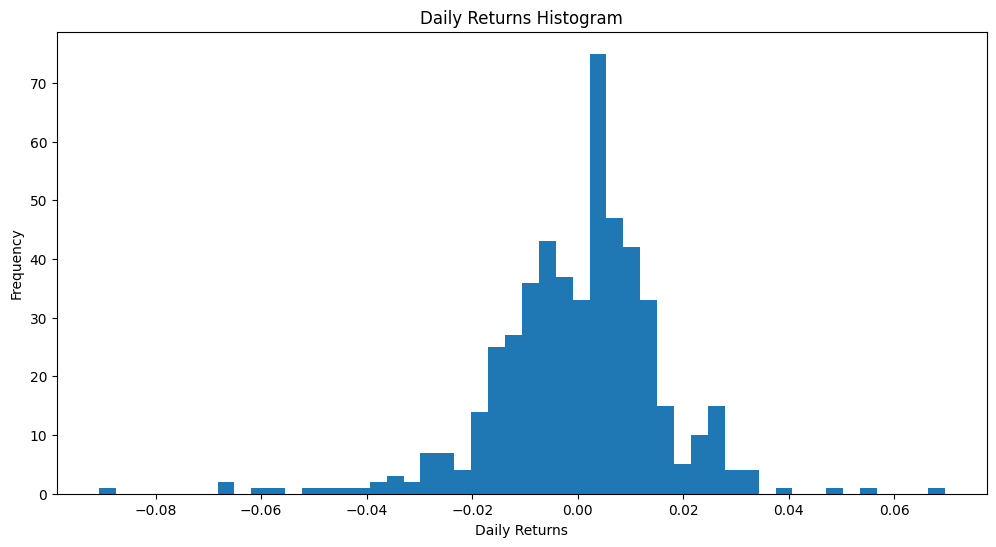

Skewness: -0.765138342066521
Kurtosis: 4.451784434894096


In [71]:
skewness = df['Returns'].skew()
kurtosis = df['Returns'].kurtosis()

plt.figure(figsize=(12, 6))
plt.hist(df['Returns'].dropna(), bins=50)
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.title('Daily Returns Histogram')
plt.show()

print(f'Skewness: {skewness}')
print(f'Kurtosis: {kurtosis}')

The data has a few outliers and is slightly skewed to the right. Given these circumstances, I will use median values to fill in the NaN values.

In [72]:
psecml = df.fillna(df.median())

psecml.head()

,Open,High,Low,Close,Volume,Average Daily Return,Returns,21D_Volatility,Daily Return Volatility,Intraday Range,20-day Moving Average,50-day Moving Average,VWAP
Date,,,,,,,,,,,,,
2021-04-01 00:00:00-04:00,6.304005,6.385875,6.271257,6.377688,1788600,0.002439,0.002436,0.013825,0.013842,0.114619,7.068798,7.07374,6.344940
2021-04-05 00:00:00-04:00,6.385877,6.451373,6.353129,6.426812,1876800,0.007703,0.007673,0.013825,0.013842,0.098244,7.068798,7.07374,6.410438
2021-04-06 00:00:00-04:00,6.451373,6.492308,6.426811,6.467747,1808800,0.006369,0.006349,0.013825,0.013842,0.065496,7.068798,7.07374,6.462289
2021-04-07 00:00:00-04:00,6.492306,6.582363,6.475932,6.516867,2948700,0.007595,0.007566,0.013825,0.013842,0.106431,7.068798,7.07374,6.525054
2021-04-08 00:00:00-04:00,6.541429,6.549616,6.443185,6.533242,1661400,0.002513,0.002510,0.013825,0.013842,0.106431,7.068798,7.07374,6.508681


Great, that's much better! Before training our model, we will conduct a few visualizations. We will look at the log returns, 21-day volatility, and the 20-day/50-day moving averages for trend analysis.

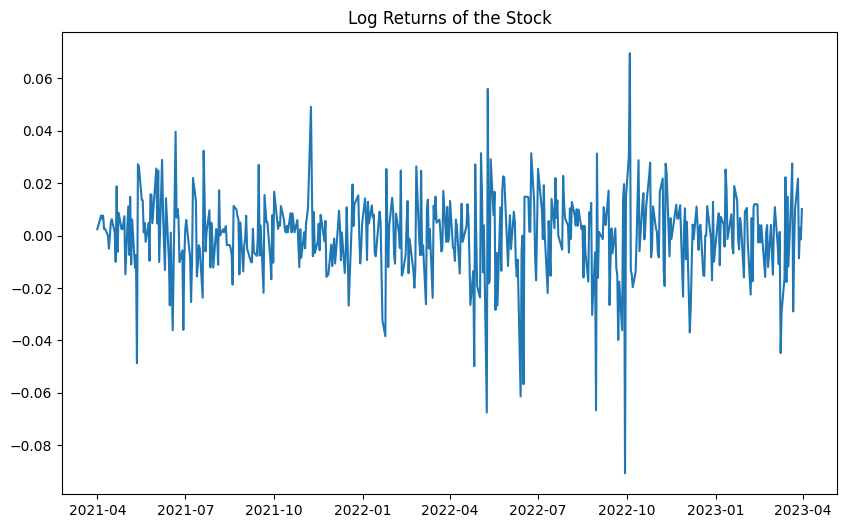

In [73]:
plt.figure(figsize=(10,6))
plt.plot(psecml.index, psecml['Returns'])
plt.title('Log Returns of the Stock')
plt.show()

21day Volatility 

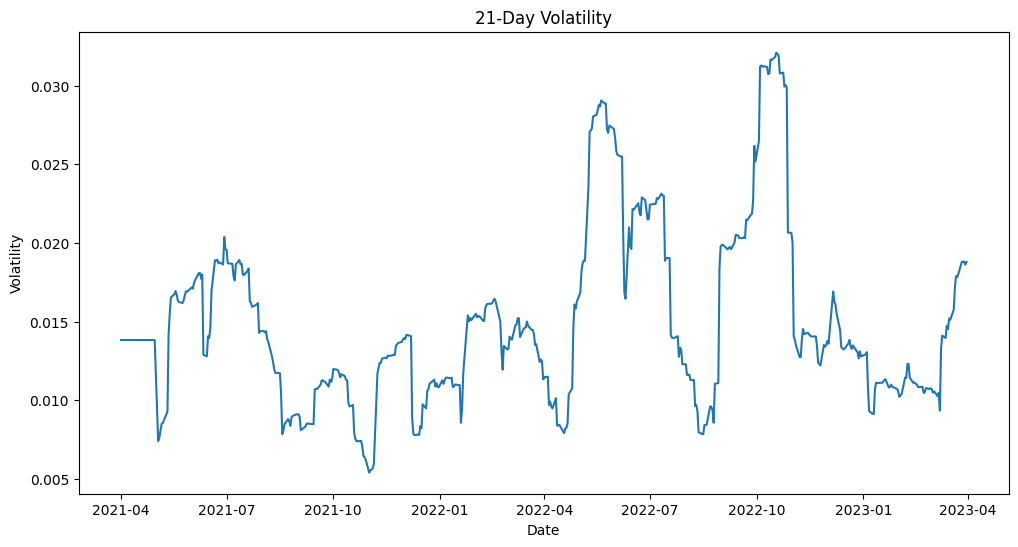

In [74]:
plt.figure(figsize=(12, 6))
plt.plot(psecml.index, psecml['21D_Volatility'])
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('21-Day Volatility')
plt.show()

20/50 Day Moving Average. Buy and Sell signals included.

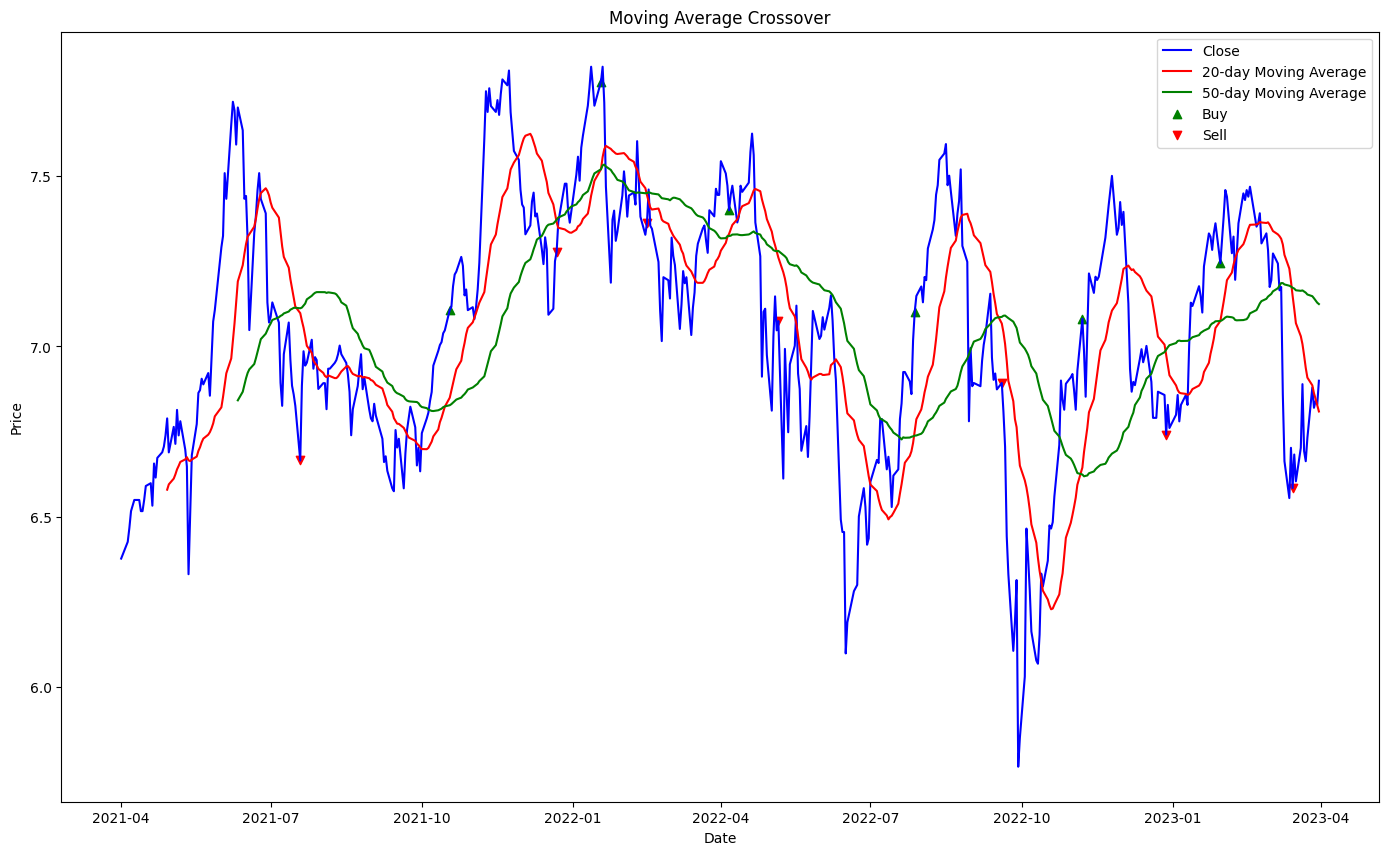

In [75]:
plt.figure(figsize=(17, 10))

# Plot Closing Price
plt.plot(df['Close'], color='blue', label='Close')

# Plot 20-day Moving Average
plt.plot(df['20-day Moving Average'], color='red', label='20-day Moving Average')

# Plot 50-day Moving Average
plt.plot(df['50-day Moving Average'], color='green', label='50-day Moving Average')

# Compute Buy and Sell signals (where the crossovers occur)
buy_signals = df[(df['20-day Moving Average'].shift(1) < df['50-day Moving Average'].shift(1)) & (df['20-day Moving Average'] > df['50-day Moving Average'])].index
sell_signals = df[(df['20-day Moving Average'].shift(1) > df['50-day Moving Average'].shift(1)) & (df['20-day Moving Average'] < df['50-day Moving Average'])].index

# Plot Buy and Sell signals
plt.scatter(buy_signals, df['Close'].loc[buy_signals], color='green', marker='^', label='Buy')
plt.scatter(sell_signals, df['Close'].loc[sell_signals], color='red', marker='v', label='Sell')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Moving Average Crossover')
plt.legend()
plt.show()



The graphs from the first project are completely different from the ones in this project. I believe that if I were to use the previous dataset, I wouldn't obtain very useful values.

Next, we're going to train a linear regression model to predict future stock returns. Be aware, however, that a simple Linear Regression model may not be able to account for all the noise in stock data, and overfitting may occur.

Let's begin by creating our features and target datasets.

In [94]:
features = ['Open', 'High', 'Low', 'Volume', 'Average Daily Return', 'Daily Return Volatility', 
            'Intraday Range', '20-day Moving Average', '50-day Moving Average', 'VWAP', '21D_Volatility']

X = psecml[features]
y = psecml['Returns']  

Next lets split the data into train and test sets

In [95]:
X_trai, X_tes, y_trai, y_tes = train_test_split(X, y, test_size=0.2, random_state=42)


Now we will create the model, train the model, and then use the trained model to get some predictions

In [96]:
model = LinearRegression()
model.fit(X_trai, y_trai)
y_pre = model.predict(X_tes)


Next, computing the Mean Square Error

In [79]:
mse = mean_squared_error(y_tes, y_pre)

print(f"Mean Squared Error: {mse: .10}")

Mean Squared Error:  9.453093369e-08


The MSE given is very small, indicating a well-performing model. However, this may be happening due to the model overfitting the data. Let's take a look at the predictions graphed with actual returns over time. Let's also examine the R-squared score

In [98]:
# Calculate the R-squared score
r2 = r2_score(y_tes, y_pre)

# Print the R-squared score
print("R-squared score:", r2)

R-squared score: 0.9997304346879015


The R-squared score explains the proportion of the variance in the target variable. The score above is very close to one, indicating once again that overfitting has occurred. To get a better picture of the overfitting, let's examine the actual and predicted values on a graph

In [99]:
# Creating a DataFrame for the predicted returns
predicted_returns = pd.DataFrame(y_pre, columns=['Predicted Returns'], index=X_tes.index)


In [100]:
# Merging with the original DataFrame to get the actual returns
psecpre = pd.merge(psecml, predicted_returns, left_index=True, right_index=True, how='outer')


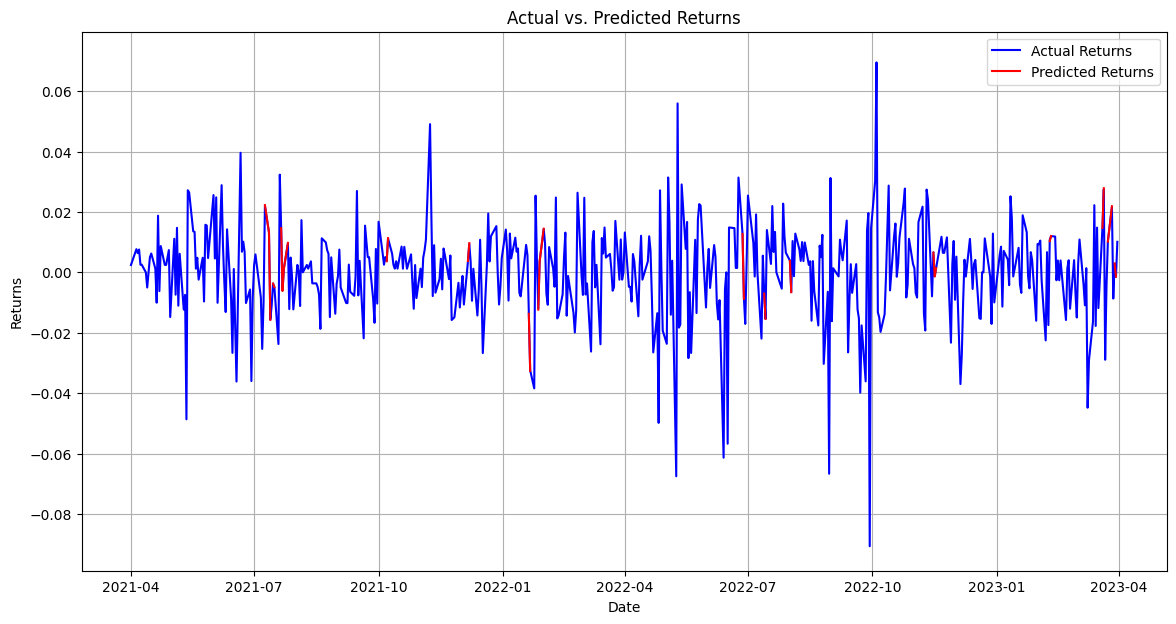

In [101]:
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(psecpre.index, psecpre['Returns'], label='Actual Returns', color='blue')
plt.plot(psecpre.index, psecpre['Predicted Returns'], label='Predicted Returns', color='red')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Actual vs. Predicted Returns')
plt.legend()
plt.grid(True)
plt.show()


The blue line represents the actual returns and the red line represents the predicted returns. Due to the model we used, we can definitely see signs of overfitting. I could go ahead and tune the model further, but doing so may not make much sense. The Linear Regression Model cannot handle the noise in stock data. We will switch to a better ML model suited for time series forecasting. We will be using an LSTM model with 10 epochs.

First, let's transform our ML dataset. The LSTM model only uses 3D values.

In [103]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(psecml)

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [104]:
# Define the number of time steps and features
time_steps = 10  # Number of time steps (input sequence length)
n_features = psecml.shape[1]  # Number of input features


We will define a sequencing function to help create our train and test sets

In [106]:
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

Now spliting the data into train and test sets

In [107]:
X_train, y_train = create_sequences(train_data, time_steps)
X_test, y_test = create_sequences(test_data, time_steps)


Model Creation and Model training 

In [108]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)

Epoch 1/10
25/25 [==============================] - 2s 7ms/step - loss: 0.1449
Epoch 2/10
25/25 [==============================] - 0s 7ms/step - loss: 0.0564
Epoch 3/10
25/25 [==============================] - 0s 6ms/step - loss: 0.0547
Epoch 4/10
25/25 [==============================] - 0s 7ms/step - loss: 0.0542
Epoch 5/10
25/25 [==============================] - 0s 7ms/step - loss: 0.0539
Epoch 6/10
25/25 [==============================] - 0s 7ms/step - loss: 0.0538
Epoch 7/10
25/25 [==============================] - 0s 7ms/step - loss: 0.0537
Epoch 8/10
25/25 [==============================] - 0s 6ms/step - loss: 0.0537
Epoch 9/10
25/25 [==============================] - 0s 6ms/step - loss: 0.0537
Epoch 10/10
25/25 [==============================] - 0s 7ms/step - loss: 0.0537


Lets generate some predictions 

In [109]:
y_pred = model.predict(X_test)

3/3 [==============================] - 0s 4ms/step


We have to transform the output values back to their orginal forms into to calculate MSE and R Squared score

In [110]:
# Reshape y_pred and y_test arrays
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

# Inverse transform the predictions and actual values to the original scale
y_pred = (y_pred * scaler.data_range_[0]) + scaler.data_min_[0]
y_test = (y_test * scaler.data_range_[0]) + scaler.data_min_[0]
y_test = y_test[:len(y_pred)]



Lets get the MSE and the R2 score

In [113]:
mse = mean_squared_error(y_test, y_pred)
print("LSTM MSE:", mse)

# Calculate the R-squared score
r2 = r2_score(y_test, y_pred)

# Print the R-squared score
print("R-squared score:", r2)

LSTM MSE: 0.3293609643374478
R-squared score: -0.024458474075753855


Getting a negative R-squared score means that this current model performs worse than a horizontal line. This suggests that the model fails to capture any patterns and may not be able to provide meaningful predictions.

We are going to try improving the performance of the model. This time, we're going to add more epochs and note the differences.

In [129]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(psecml)

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Define the number of time steps and features
time_step = 20  # Number of time steps (input sequence length)
n_features = psecml.shape[1]  # Number of input features

def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_step, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1)



Epoch 1/20
24/24 [==============================] - 2s 12ms/step - loss: 0.0954
Epoch 2/20
24/24 [==============================] - 0s 11ms/step - loss: 0.0570
Epoch 3/20
24/24 [==============================] - 0s 11ms/step - loss: 0.0553
Epoch 4/20
24/24 [==============================] - 0s 11ms/step - loss: 0.0551
Epoch 5/20
24/24 [==============================] - 0s 11ms/step - loss: 0.0549
Epoch 6/20
24/24 [==============================] - 0s 11ms/step - loss: 0.0547
Epoch 7/20
24/24 [==============================] - 0s 10ms/step - loss: 0.0546
Epoch 8/20
24/24 [==============================] - 0s 17ms/step - loss: 0.0546
Epoch 9/20
24/24 [==============================] - 0s 17ms/step - loss: 0.0545
Epoch 10/20
24/24 [==============================] - 1s 20ms/step - loss: 0.0545
Epoch 11/20
24/24 [==============================] - 1s 30ms/step - loss: 0.0545
Epoch 12/20
24/24 [==============================] - 1s 27ms/step - loss: 0.0545
Epoch 13/20
24/24 [==================

In [130]:
y_pred = model.predict(X_test)

# Reshape y_pred and y_test arrays
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

# Inverse transform the predictions and actual values to the original scale
y_pred = (y_pred * scaler.data_range_[0]) + scaler.data_min_[0]
y_test = (y_test * scaler.data_range_[0]) + scaler.data_min_[0]
y_test = y_test[:len(y_pred)]

3/3 [==============================] - 0s 7ms/step


In [131]:
mse = mean_squared_error(y_test, y_pred)
print("LSTM MSE:", mse)

# Calculate the R-squared score
r2 = r2_score(y_test, y_pred)

# Print the R-squared score
print("R-squared score:", r2)

LSTM MSE: 0.1622973376617535
R-squared score: -0.07159495020158135


Changing the epochs to 20 lowered the MSE and reduced the R-squared score. This is due to the fact that increasing epochs can lead to overfitting

What did I learn?

Trying to predict stock returns is a difficult task due to the many features affecting the stock price. It will require a model that can account for this noise in order to make accurate predictions. The next steps are as follows:

1. Try adding new features to the dataset.
2. Consider using a larger timeframe.
3. Change the model structure.
4. Apply a regularization technique to help with overfitting.